In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.sql.functions import dayofweek
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from pyspark.ml import Pipeline

In [2]:
spark = SparkSession\
        .builder\
        .appName("proj")\
        .config("spark.some.config.option", "some-value")\
        .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=proj>

## Load and preprocess the data 

In [3]:
data311 = spark.read.format("csv") \
    .option("header", "true") \
    .load("Data_Final/*.csv")
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
data311.registerTempTable("data311")

In [4]:
data311

DataFrame[Created Date: string, Closed Date: string, Complaint Type: string, Descriptor: string, Location Type: string, Incident Zip: string, City: string, Status: string, Resolution Description: string, Resolution Action Updated Date: string, Borough: string, Latitude: string, Longitude: string, Complaint_Type_Groups: string, Resolution_Type_Groups: string, Location_Type_Groups: string, Resolution_Time_Secs: string, Resolution_Time_Mins: string, Resolution_Time_Hours: string]

Create day of the week column and Resolve zipcode and day column to integers

In [5]:
data311 = data311.withColumn("ResTimeH", data311.Resolution_Time_Hours.cast('int'))
data311 = data311.withColumn('day_of_week',dayofweek(data311['Created Date']))
data311 = data311.withColumn("Zip", data311["Incident Zip"].cast('int'))
#data311 = data311.withColumn("Lati", data311["Latitude"].cast('int'))
#data311 = data311.withColumn("Long", data311["Longitude"].cast('int'))

Outlier removal - removing rows with resolution time less than 0 and greater than 99

In [6]:
data311 = data311.filter(data311.ResTimeH >0) 
data311 = data311.filter(data311.ResTimeH <36) 

Removing null values 

In [7]:
data311 = data311.filter(data311["Zip"]. isNotNull())
data311 = data311.filter(data311["Complaint_Type_Groups"]. isNotNull())
data311 = data311.filter(data311["day_of_week"]. isNotNull())
#data311 = data311.filter(data311["Lati"]. isNotNull())
#data311 = data311.filter(data311["Long"]. isNotNull())

### Analyzing Resolution Times 

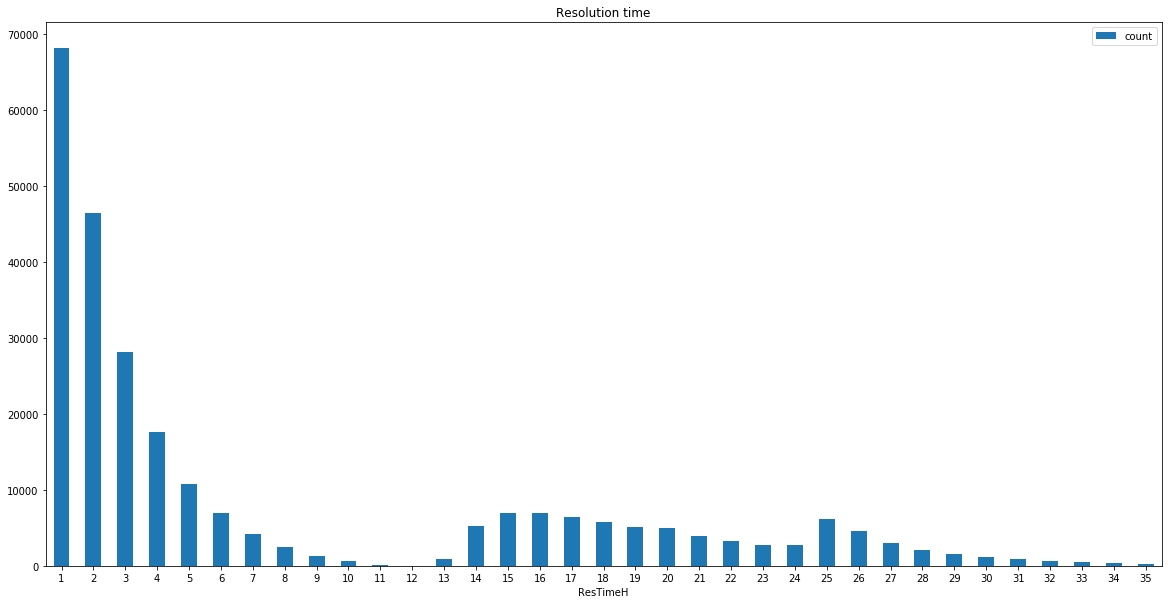

In [8]:
ResTimeH_counts = data311.groupBy("ResTimeH").count().orderBy("ResTimeH")
plot = ResTimeH_counts.toPandas()
plot.plot.bar(x="ResTimeH", y="count", rot=0, figsize=(20, 10), title = "Resolution time");

### Spliting output column (Resolution time) into buckets or categories

In [10]:
bucketizer = Bucketizer(splits=[ 0,2,6,float('Inf') ],inputCol="ResTimeH", outputCol="categories")
data31 = bucketizer.setHandleInvalid("keep").transform(data311)
data31.groupBy("categories").count().show()

+----------+------+
|categories| count|
+----------+------+
|       0.0| 68191|
|       1.0|102978|
|       2.0| 92011|
+----------+------+



### Dataframe with required columns 

In [11]:
X = data31['Zip', 'Complaint_Type_Groups','day_of_week', 'categories']
X.show(5)

+-----+---------------------+-----------+----------+
|  Zip|Complaint_Type_Groups|day_of_week|categories|
+-----+---------------------+-----------+----------+
|10034|                Noise|          5|       2.0|
|11105|   Parking Conditions|          5|       2.0|
|10458|   Parking Conditions|          5|       2.0|
|10461|   Parking Conditions|          5|       2.0|
|11373|   Parking Conditions|          5|       2.0|
+-----+---------------------+-----------+----------+
only showing top 5 rows



# Logistic Regression

###### Stage 1 - 
Index the string in "Complaint type groups"

In [12]:
indexer = StringIndexer(inputCol="Complaint_Type_Groups", outputCol="categoryIndex")
stage1_data = indexer.fit(X).transform(X)
stage1_data.show(5)

+-----+---------------------+-----------+----------+-------------+
|  Zip|Complaint_Type_Groups|day_of_week|categories|categoryIndex|
+-----+---------------------+-----------+----------+-------------+
|10034|                Noise|          5|       2.0|          1.0|
|11105|   Parking Conditions|          5|       2.0|          0.0|
|10458|   Parking Conditions|          5|       2.0|          0.0|
|10461|   Parking Conditions|          5|       2.0|          0.0|
|11373|   Parking Conditions|          5|       2.0|          0.0|
+-----+---------------------+-----------+----------+-------------+
only showing top 5 rows



###### Stage 2 -
One hot encode the indexed complaint type group

In [13]:
encoder = OneHotEncoderEstimator(inputCols=["categoryIndex"],outputCols=["categoryVec"])
stage2_data = encoder.fit(stage1_data).transform(stage1_data)
stage2_data.show(5)

+-----+---------------------+-----------+----------+-------------+-------------+
|  Zip|Complaint_Type_Groups|day_of_week|categories|categoryIndex|  categoryVec|
+-----+---------------------+-----------+----------+-------------+-------------+
|10034|                Noise|          5|       2.0|          1.0|(5,[1],[1.0])|
|11105|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|
|10458|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|
|10461|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|
|11373|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|
+-----+---------------------+-----------+----------+-------------+-------------+
only showing top 5 rows



###### Stage 3 -
Transform input features into vectors

In [14]:
assembler = VectorAssembler(inputCols=['Zip', 'day_of_week', 'categoryVec'],outputCol="features")
stage3_data = assembler.transform(stage2_data)
stage3_data.show(5)

+-----+---------------------+-----------+----------+-------------+-------------+--------------------+
|  Zip|Complaint_Type_Groups|day_of_week|categories|categoryIndex|  categoryVec|            features|
+-----+---------------------+-----------+----------+-------------+-------------+--------------------+
|10034|                Noise|          5|       2.0|          1.0|(5,[1],[1.0])|(7,[0,1,3],[10034...|
|11105|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[11105...|
|10458|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[10458...|
|10461|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[10461...|
|11373|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[11373...|
+-----+---------------------+-----------+----------+-------------+-------------+--------------------+
only showing top 5 rows



###### Stage 4 -
Standard scale the feature vector

In [15]:
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
stage4_data = standardscaler.fit(stage3_data).transform(stage3_data)
stage4_data.show(5)

+-----+---------------------+-----------+----------+-------------+-------------+--------------------+--------------------+
|  Zip|Complaint_Type_Groups|day_of_week|categories|categoryIndex|  categoryVec|            features|     Scaled_features|
+-----+---------------------+-----------+----------+-------------+-------------+--------------------+--------------------+
|10034|                Noise|          5|       2.0|          1.0|(5,[1],[1.0])|(7,[0,1,3],[10034...|(7,[0,1,3],[17.28...|
|11105|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[11105...|(7,[0,1,2],[19.12...|
|10458|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[10458...|(7,[0,1,2],[18.01...|
|10461|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[10461...|(7,[0,1,2],[18.02...|
|11373|   Parking Conditions|          5|       2.0|          0.0|(5,[0],[1.0])|(7,[0,1,2],[11373...|(7,[0,1,2],[19.59...|
+-----+---------

###### Stage 5 -
Logistic regression on the scaled feature vector to predict the categories

In [16]:
train, test = stage4_data.randomSplit([0.9, 0.1], seed = 2018)
mlr = LogisticRegression(labelCol="categories",featuresCol="Scaled_features")
mlrModel = mlr.fit(train)

In [17]:
trainingSummary = mlrModel.summary
accuracy = trainingSummary.accuracy

print(accuracy*100)

40.788517748829975


Testing Logistic Regressor model on test data

In [18]:
predictions = mlrModel.transform(test)
predictions.groupBy("prediction").count().show()
predictions.groupBy("categories").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|    9|
|       1.0|17524|
|       2.0| 8899|
+----------+-----+

+----------+-----+
|categories|count|
+----------+-----+
|       0.0| 6902|
|       1.0|10282|
|       2.0| 9248|
+----------+-----+



# Pipeline

In [19]:
stage_1 = StringIndexer(inputCol="Complaint_Type_Groups", outputCol="categoryIndex")

stage_2 = OneHotEncoderEstimator(inputCols=["categoryIndex"],outputCols=["categoryVec"])

stage_3 = VectorAssembler(inputCols=['Zip', 'day_of_week', 'categoryVec'],outputCol="features")

stage_4 = StandardScaler().setInputCol("features").setOutputCol("Scaled_ip_features")

stage_5 = LogisticRegression(labelCol="categories",featuresCol="Scaled_ip_features")

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(X)

### Testing for user-defined input

In [28]:
def check_prediction(ans):
    if (ans[0]==0.0):
        prediction="Your complaint will be resolved within 2 hours."
    elif (ans[0]==1.0):
        prediction="Your complaint will be resolved within 2-6 hours."
    else:
        prediction="Your complaint will be resolved anytime after 6 hours"
    return prediction

###### TEST 1

In [41]:
zipcode = 11210
complaint = "Noise"
day = 3

input_variables = pd.DataFrame([[zipcode, complaint, day]], columns=['Zip', 'Complaint_Type_Groups', 'day_of_week'])
input_variables = spark.createDataFrame(input_variables)
input_variables.show()

+-----+---------------------+-----------+
|  Zip|Complaint_Type_Groups|day_of_week|
+-----+---------------------+-----------+
|11210|                Noise|          3|
+-----+---------------------+-----------+



Select the predicted category and resolve it as string

In [42]:
transformed = pipeline_model.transform(input_variables)
ans = transformed.select(collect_list('prediction')).first()[0]
prediction = check_prediction(ans)
print(prediction)

Your complaint will be resolved anytime after 6 hours


###### TEST 2

In [37]:
zipcode = 11209
complaint = "Traffic"
day = 3

input_variables = pd.DataFrame([[zipcode, complaint, day]], columns=['Zip', 'Complaint_Type_Groups', 'day_of_week'])
input_variables = spark.createDataFrame(input_variables)
input_variables.show()

+-----+---------------------+-----------+
|  Zip|Complaint_Type_Groups|day_of_week|
+-----+---------------------+-----------+
|11209|              Traffic|          3|
+-----+---------------------+-----------+



In [38]:
transformed = pipeline_model.transform(input_variables)
ans = transformed.select(collect_list('prediction')).first()[0]
prediction = check_prediction(ans)
print(prediction)

Your complaint will be resolved within 2-6 hours.


##### TEST 3

In [29]:
zipcode = 83
complaint = "Noise"
day = 5

input_variables = pd.DataFrame([[zipcode, complaint, day]], columns=['Zip', 'Complaint_Type_Groups', 'day_of_week'])
input_variables = spark.createDataFrame(input_variables)
input_variables.show()

+---+---------------------+-----------+
|Zip|Complaint_Type_Groups|day_of_week|
+---+---------------------+-----------+
| 83|                Noise|          5|
+---+---------------------+-----------+



In [30]:
transformed = pipeline_model.transform(input_variables)
ans = transformed.select(collect_list('prediction')).first()[0]
prediction = check_prediction(ans)
print(prediction)

Your complaint will be resolved within 2 hours.
